# User prompt
The user define the research objective a prompt. I use openAI to identify relevant key words for the research.
Documentation:
* https://platform.openai.com/docs/guides/text?api-mode=responses&lang=python

In [1]:
import os
from dotenv import load_dotenv
from openai import OpenAI
from openai.types.responses import Response

# Load the API key
load_dotenv()

client: OpenAI = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Research objective
research_objective: str = """
At present, one of our clients is looking to speak with professionals who have insights about the emerging technologies 
in soft contact lens manufacturing, particularly non-injection moulded methods. They would broadly like to understand how 
these technologies are reshaping the industry—from on-demand manufacturing to smart, drug-delivery-enabled lenses.
"""
# TODO: improve the prompt to extract words from the research objective
prompt: str = f"""
You are assisting a researcher in generating targeted search terms for academic and patent literature related to the research topic described below.

Return a JSON object with the following structure:
- "main_topic": a concise list of words (2–3 words) extracted from the Research Objective that reflects the core technological focus
- "openalex": exactly 5 academic search terms, extracted from the Research Objective that reflects the client objective
- "patentview": exactly 5 patent-related keywords, extracted from the Research Objective that reflects the client objective
- "cpc_codes": exactly 5 valid CPC classification codes relevant to the topic

Instructions:
- Output must be valid JSON only — no markdown, comments, or extra text
- All terms in "openalex" and "patentview" must be single or double words
- Do NOT include any words or close variants from "main_topic" in "openalex" or "patentview"
- All terms across the fields must be unique — no repetition or synonyms
- Each term in "openalex" and "patentview" must be conceptually compatible with the "main_topic" so that combining them (e.g. "main_topic" AND "keyword") produces a realistic and meaningful research query
- Use language and terminology commonly found in scientific publications and patent documents

Research Objective:
\"\"\" 
{research_objective} 
\"\"\"
"""

# Selected model
# model="gpt-3.5-turbo",
# model="gpt-4-turbo",
# model="gpt-4o", 
GPT_MODEL = "gpt-4o-mini"

response: Response = client.responses.create(

    model=GPT_MODEL,
    input = prompt
)

print(f"The lenght of research objective is: {len(research_objective)}")

# print(type(response))
print(response.output_text)

The lenght of research objective is: 360
{
  "main_topic": ["soft contact lenses"],
  "openalex": [
    "emerging technologies",
    "on-demand manufacturing",
    "smart lenses",
    "drug delivery",
    "manufacturing methods"
  ],
  "patentview": [
    "non-injection molding",
    "lens fabrication",
    "chemical treatment",
    "biocompatibility",
    "optical properties"
  ],
  "cpc_codes": [
    "G02C7/00",
    "B29C33/00",
    "A61F2/00",
    "B29D99/00",
    "C08L63/00"
  ]
}


In [2]:
import json

def load_json(response_output: Response) -> dict[str, str | list[str]]:
    # Load the json file into dictionary
    json_dict:dict[str, str | list[str]] = json.loads(response_output)
    # print("Parsed dict:", research_key_words)
    return json_dict

# Print the main topic
research_key_words = load_json(response.output_text)
print(research_key_words["main_topic"])
# print(research_key_words["openalex"][0])

['soft contact lenses']


# Openalex API
https://docs.openalex.org/

Valid parameters are: 
* apc_sum, 
* cited_by_count_sum, 
* cursor, 
* filter, 
* format, 
* group_by, 
* group-by, 
* group_bys, 
* group-bys, 
* mailto, 
* page, 
* per_page, 
* per-page, 
* q, 
* sample, 
* seed, 
* search, 
* select, 
* sort, 
* warm.'

## API calls to load papers

In [99]:
import requests
import pandas as pd
from typing import Any

def reconstruct_abstract(abstract_inverted_index: dict[str, list[int]]) -> str:
    '''
    Reconstruct the abstract from abstract_inverted_index
    '''
    
    # Some works don't have an abstract
    if not abstract_inverted_index:
        return ""
        
    # Variable to store the highest index
    max_value: int = 0
     # Loop through all the list of position in the abstract_inverted_index dictionary.
    for values in abstract_inverted_index.values():
        # Loop through all the index value
        for value in values:
            # identify the highest value index
            if value >= max_value:
                max_value = value
                
    # Create an empty list with abstract size        
    abstract: list[str] = [None] * (max_value +1)

    # Loop through each word in the abstract_inverted_index:
    for word, positions in abstract_inverted_index.items():
        # For each word, get the list of positions it appears in.
        for position in positions:
            # Insert each word into its correct position in the list.
            abstract[position]= word
                        
    # Join all the words in the list into a single string, separated by spaces.
    # abstract_text: str = " ".join(abstract)
    abstract_text: str = " ".join(word if word is not None else "" for word in abstract)

    # print("\n", abstract_text)
    
    return abstract_text

# Openalex url
url: str = "https://api.openalex.org/works"

# TODO: make a search by years: for example in the last 10 years
main_topic: str = research_key_words["main_topic"]

# research_key_word: str = research_key_words["openalex"][0]

# search_terms: str = f"({main_topic} AND {research_key_word})"
mailto: str = "adyl.elguamra@gmail.com" #For best performance, add your email to all API requests

per_page: int = 50 # By default there are 25 results per page
page: int = 1 # Get the result from page number

# Extend the list of key words
all_key_words = research_key_words["openalex"] + research_key_words["patentview"]

# Collect all results
all_records = []

for research_key_word in all_key_words:
    search_terms = f"({main_topic} AND {research_key_word})"

    params = {
        "search": search_terms,
        "per_page": per_page,
        "page": page,
        "sort": "relevance_score:desc",
        "mailto": mailto
    }

    response = requests.get(url, params=params)
    print("Final URL:", response.url)

    if response.status_code == 200:
        data: dict[str, Any] = response.json()
        works: list[dict[str, Any]] = data.get("results", [])

        for work in works:
            abstract_inverted_index = work.get("abstract_inverted_index", {})
            abstract = reconstruct_abstract(abstract_inverted_index)

            authorships = work.get("authorships", [])
            authors = [auth["author"]["display_name"] for auth in authorships]

            first_institution = None
            main_country = None
            if authorships:
                first_author = authorships[0]
                institutions = first_author.get("institutions", [])
                if institutions:
                    first_institution = institutions[0].get("display_name")
                    main_country = institutions[0].get("country_code")

            record = {
                "keyword": research_key_word,
                "title": work.get("title"),
                "abstract": abstract,
                "publication_date": work.get("publication_date"),
                "year": work.get("publication_year"),
                "citations": work.get("cited_by_count"),
                "authors": authors,
                "institution": first_institution,
                "country": main_country,
                "openAlex_id": work.get("id"),
            }

            all_records.append(record)
    else:
        print(f"Failed for keyword '{research_key_word}'. Status: {response.status_code}")
        print(response.text)

# Create DataFrame
df = pd.DataFrame(all_records)

print(f"\nDataFrame shape: {df.shape}")  # (rows, columns)


Final URL: https://api.openalex.org/works?search=%28%5B%27soft+contact+lenses%27%5D+AND+emerging+technologies%29&per_page=50&page=1&sort=relevance_score%3Adesc&mailto=adyl.elguamra%40gmail.com
Final URL: https://api.openalex.org/works?search=%28%5B%27soft+contact+lenses%27%5D+AND+on-demand+manufacturing%29&per_page=50&page=1&sort=relevance_score%3Adesc&mailto=adyl.elguamra%40gmail.com
Final URL: https://api.openalex.org/works?search=%28%5B%27soft+contact+lenses%27%5D+AND+smart+lenses%29&per_page=50&page=1&sort=relevance_score%3Adesc&mailto=adyl.elguamra%40gmail.com
Final URL: https://api.openalex.org/works?search=%28%5B%27soft+contact+lenses%27%5D+AND+drug+delivery%29&per_page=50&page=1&sort=relevance_score%3Adesc&mailto=adyl.elguamra%40gmail.com
Final URL: https://api.openalex.org/works?search=%28%5B%27soft+contact+lenses%27%5D+AND+manufacturing+methods%29&per_page=50&page=1&sort=relevance_score%3Adesc&mailto=adyl.elguamra%40gmail.com
Final URL: https://api.openalex.org/works?search=%

In [100]:
# Print the dataframe
df.head()

,keyword,title,abstract,publication_date,year,citations,authors,institution,country,openAlex_id
0,emerging technologies,Situated Knowledges: The Science Question in Feminism and the Privilege of Partial Perspective,,1988-01-01,1988,15172,[Donna Haraway],None,None,https://openalex.org/W3146083582
1,emerging technologies,Poly(2-Hydroxyethyl Methacrylate) Hydrogels for Contact Lens Applications–A Review,"The emerging technology in biomedical engineering requires biocompatible materials, which are also referred to as biomaterials. For a material to be considered biocompatible, it should not interact with human tissues in a harmful way, and vice versa. Various properties of biocompatible materials, such as mechanical and optical properties, have to be considered for different biomedical applications. One of the most popular applications of biomaterials is for contact lenses. Hydrogels, specifically poly(2-hydroxyethyl methacrylate) (PHEMA) hydrogels, are among the most popular ones in ophthalmologic applications, especially in soft contact lenses. This paper reviews the use of PHEMA hydrogels as one of the important biomaterials. The possible applications, properties, and manufacturing process of PHEMA hydrogels, especially in contact lens applications, are addressed. Many studies have shown that PHEMA hydrogels possess many advantages in contact lens applications and have promising development prospects.",2021-09-29,2021,11,"[Kushendarsyah Saptaji, Nurlaely Rohmatul, Sinta Widianingrum, Vania Katherine Mulia, Iwan Setiawan, Nurlaely Rohmatul Iza]",Sampoerna University,ID,https://openalex.org/W3208579006
2,emerging technologies,Soft Lithography Using Nectar Droplets,"In spite of significant advances in replication technologies, methods to produce well-defined three-dimensional structures are still at its infancy. Such a limitation would be evident if we were to produce a large array of simple and, especially, compound convex lenses, also guaranteeing that their surfaces would be molecularly smooth. Here, we report a novel method to produce such structures by cloning the 3D shape of nectar drops, found widely in nature, using conventional soft lithography.The elementary process involves transfer of a thin patch of the sugar solution coated on a glass slide onto a hydrophobic substrate on which this patch evolves into a microdroplet. Upon the absorption of water vapor, such a microdroplet grows linearly with time, and its final size can be controlled by varying its exposure time to water vapor. At any stage of the evolution of the size of the drop, its shape can be cloned onto a soft elastomer by following the well-known methods of molding and cross-linking the same. A unique new science that emerges in our attempt to understand the transfer of the sugar patch and its evolution to a spherical drop is the elucidation of the mechanics underlying the contact of a deformable sphere against a solid support intervening a thin liquid film. A unique aspect of this work is to demonstrate that higher level structures can also be generated by transferring even smaller nucleation sites on the surface of the primary lenses and then allowing them to grow by absorption of water vapor. What results at the end is either a well-controlled distribution of smooth hemispherical lenses or compound structures that could have potential applications in the fundamental studies of contact mechanics, wettability, and even in optics.",2015-11-13,2015,17,"[Saheli Biswas, Aditi Chakrabarti, Antoine Chateauminois, Élie Wandersman, Alexis Prevost, Manoj K. Chaudhury]",Lehigh University,US,https://openalex.org/W2407997879
3,emerging technologies,Biomolecular condensates: organizers of cellular biochemistry,,2017-02-22,2017,5079,"[Salman F. Banani, Hyun O. Lee, Anthony A. Hyman, Michael K. Rosen]",The University of Texas Southwestern Medical Center,US,https://openalex.org/W2590568317
4,emerging technologies,What we know about the scleral profile and its impact on cont

## Identify relevant papers

Documentation:
* https://python.langchain.com/docs/tutorials/rag/#overview 
* https://scalexi.medium.com/implementing-a-retrieval-augmented-generation-rag-system-with-openais-api-using-langchain-ab39b60b4d9f
* https://platform.openai.com/docs/guides/embeddings
* https://python.langchain.com/docs/tutorials/retrievers/
* https://cookbook.openai.com/examples/get_embeddings_from_dataset

In [101]:
# 1. **Create a new column** in the DataFrame that combines the title and abstract into a single `text` field for each paper.
df["text"] = df["title"] + ". " + df["abstract"]


df["relevant"] = ""
df["justification"] = ""

df[["title", "publication_date", "country", "institution"]].head(10)

,title,publication_date,country,institution
0,Situated Knowledges: The Science Question in Feminism and the Privilege of Partial Perspective,1988-01-01,None,None
1,Poly(2-Hydroxyethyl Methacrylate) Hydrogels for Contact Lens Applications–A Review,2021-09-29,ID,Sampoerna University
2,Soft Lithography Using Nectar Droplets,2015-11-13,US,Lehigh University
3,Biomolecular condensates: organizers of cellular biochemistry,2017-02-22,US,The University of Texas Southwestern Medical Center
4,What we know about the scleral profile and its impact on contact lens fitting,2022-07-11,None,None
5,Keratoconus,1998-01-01,US,Cedars-Sinai Medical Center
6,Far-Field Optical Nanoscopy,2007-05-25,DE,Max Planck Institute for Biophysical Chemistry
7,Managing Strategic Contradictions: A Top Management Model for Managing Innovation Streams,2005-10-01,US,Harvard University
8,Engineering precision nanoparticles for drug delivery,2020-12-04,US,University of Pennsylvania
9,Efficacy in Myopia Control: Does Race Matter?,2022-12-13,US,University of Houston


In [102]:
def get_justification(title, abstract, objective):
    prompt = f"""
    You are the CEO, as well as a scientific and regulatory analyst, evaluating academic research for a company .

    Below is a paper's title and abstract, followed by the company's research objective. 
    
    Title:  
    {title}

    Abstract:  
    {abstract}

    Research Objective:  
    {objective}

    Assess if the paper is relevant. Start the answer with Yes or No, followed by a 1–2 sentence explanation based only on the title and abstract. 
    Be concise, specific, and fact-based. Avoid speculation or vague generalizations.
    """

    # print("Generating GPT justifications...")
    
    try:
        response: Response = client.responses.create(
        model=GPT_MODEL,
        input = prompt
        )
        return response.output_text
    except Exception as e:
        return f"ERROR: {e}"
    



In [103]:
for i, row in df.iterrows():
    # output = evaluate_paper(row["text"])
    output = get_justification(row["title"], row["abstract"], research_objective)
    if output.lower().startswith("yes"):
        df.at[i, "relevant"] = "yes"
    elif output.lower().startswith("no"):
        df.at[i, "relevant"] = "no"
    else:
        df.at[i, "relevant"] = "unclear"
    df.at[i, "justification"] = output


In [105]:
# Show full column contents and more columns
pd.set_option("display.max_colwidth", None)    # Show full text in cells

print(len(df[df["relevant"]=="yes"]))
df[df["relevant"]=="yes"][["title","keyword","country", "institution", "publication_date", "justification"]].head(15)

301


,title,keyword,country,institution,publication_date,justification
1,Poly(2-Hydroxyethyl Methacrylate) Hydrogels for Contact Lens Applications–A Review,emerging technologies,ID,Sampoerna University,2021-09-29,"Yes, the paper is relevant as it reviews poly(2-hydroxyethyl methacrylate) hydrogels, a key material used in soft contact lens applications, focusing on their properties and manufacturing processes. This aligns with the client's interest in emerging technologies in soft contact lens manufacturing, including non-injection molded methods."
2,Soft Lithography Using Nectar Droplets,emerging technologies,US,Lehigh University,2015-11-13,"Yes, the paper is relevant as it presents a novel soft lithography method for producing well-defined three-dimensional structures, specifically discussing the creation of smooth hemispherical lenses. This aligns with the client's interest in non-injection moulded methods and innovations in contact lens manufacturing."
23,Wearable smart sensor systems integrated on soft contact lenses for wireless ocular diagnostics,emerging technologies,KR,Ulsan National Institute of Science and Technology,2017-04-27,"Yes, the paper is relevant as it discusses the development of multifunctional contact lens sensors that can monitor multiple physiological parameters, which aligns with the client's interest in emerging technologies and innovations in soft contact lens manufacturing. Additionally, the focus on integrating smart features into the lenses directly relates to the research objective of exploring advancements in the industry."
51,Biomedical applications of hydrogels: A review of patents and commercial products,on-demand manufacturing,GB,University of Reading,2014-11-29,"Yes, the paper is relevant as it discusses hydrogels, which are critical materials in the manufacturing of soft contact lenses. Additionally, the review covers recent advancements and applications that could relate to non-injection moulded methods and innovations in smart lens technologies."
94,Projection micro stereolithography based 3D printing and its applications,on-demand manufacturing,CN,Southern University of Science and Technology,2020-04-27,"Yes, the paper is relevant as it discusses projection micro stereolithography (P μ SL), a high-resolution 3D printing technology capable of fabricating complex structures, which could be applied in the development of advanced soft contact lenses, particularly in non-injection moulded methods. The review of multimaterial printing and suitable photopolymers may directly inform innovations in contact lens manufacturing, especially in creating smart and drug-delivery-enabled lenses."
99,Design and Applications of Photoresponsive Hydrogels,on-demand manufacturing,DE,Karlsruhe Institute of Technology,2019-03-08,"Yes, the paper is relevant. It discusses photoresponsive hydrogels, which can be critical in the development of smart contact lenses with advanced functionalities, including drug delivery, using non-injection molded methods. The focus on light-responsive materials aligns well with the client's interest in emerging technologies in soft contact lens manufacturing."
100,"Soft, smart contact lenses with integrations of wireless circuits, glucose sensors, and displays",smart lenses,KR,Ulsan National Institute of Science and Technology,2018-01-05,"Yes, the paper is relevant. It discusses the development of smart contact lenses with integrated sensors and wireless technology, aligning with the client's interest in emerging technologies in soft contact lens manufacturing and innovative applications like real-time diabetes monitoring."
101,Wearable smart sensor systems integrated on soft contact lenses for wireless ocular diagnostics,smart lenses,KR,Ulsan National Institute of Science and Technology,2017-04-27,"Yes, the paper is relevant as it discusses the development of multifunctional smart contact lenses that incorporate advanced sensor technologies for ocular diagnostics. This aligns with the 

## Openalex: trends in relevant papers
* Could we identify that confirms the trends?



In [106]:
oa_trends_df = df[df["relevant"]=="yes"].copy()
oa_trends_df[["title","keyword","country", "institution", "publication_date", "justification"]].head()

,title,keyword,country,institution,publication_date,justification
1,Poly(2-Hydroxyethyl Methacrylate) Hydrogels for Contact Lens Applications–A Review,emerging technologies,ID,Sampoerna University,2021-09-29,"Yes, the paper is relevant as it reviews poly(2-hydroxyethyl methacrylate) hydrogels, a key material used in soft contact lens applications, focusing on their properties and manufacturing processes. This aligns with the client's interest in emerging technologies in soft contact lens manufacturing, including non-injection molded methods."
2,Soft Lithography Using Nectar Droplets,emerging technologies,US,Lehigh University,2015-11-13,"Yes, the paper is relevant as it presents a novel soft lithography method for producing well-defined three-dimensional structures, specifically discussing the creation of smooth hemispherical lenses. This aligns with the client's interest in non-injection moulded methods and innovations in contact lens manufacturing."
23,Wearable smart sensor systems integrated on soft contact lenses for wireless ocular diagnostics,emerging technologies,KR,Ulsan National Institute of Science and Technology,2017-04-27,"Yes, the paper is relevant as it discusses the development of multifunctional contact lens sensors that can monitor multiple physiological parameters, which aligns with the client's interest in emerging technologies and innovations in soft contact lens manufacturing. Additionally, the focus on integrating smart features into the lenses directly relates to the research objective of exploring advancements in the industry."
51,Biomedical applications of hydrogels: A review of patents and commercial products,on-demand manufacturing,GB,University of Reading,2014-11-29,"Yes, the paper is relevant as it discusses hydrogels, which are critical materials in the manufacturing of soft contact lenses. Additionally, the review covers recent advancements and applications that could relate to non-injection moulded methods and innovations in smart lens technologies."
94,Projection micro stereolithography based 3D printing and its applications,on-demand manufacturing,CN,Southern University of Science and Technology,2020-04-27,"Yes, the paper is relevant as it discusses projection micro stereolithography (P μ SL), a high-resolution 3D printing technology capable of fabricating complex structures, which could be applied in the development of advanced soft contact lenses, particularly in non-injection moulded methods. The review of multimaterial printing and suitable photopolymers may directly inform innovations in contact lens manufacturing, especially in creating smart and drug-delivery-enabled lenses."


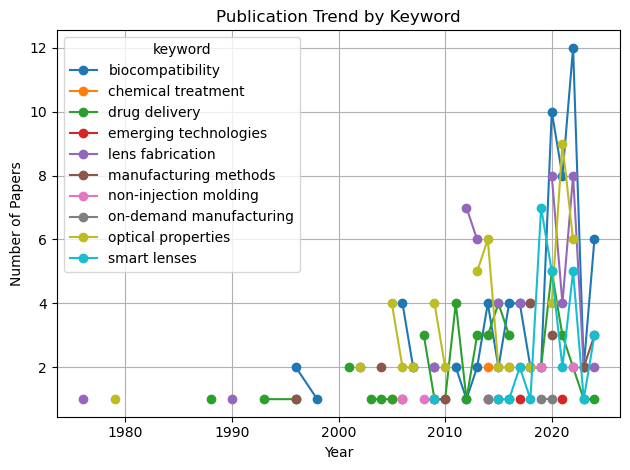

In [107]:
import pandas as pd
import matplotlib.pyplot as plt

oa_trends_df['year'] = pd.to_datetime(oa_trends_df['publication_date']).dt.year

oa_trends_df.groupby(['year', 'keyword']).size().unstack().plot(
    kind='line',
    marker='o',
    title='Publication Trend by Keyword'
)
plt.ylabel('Number of Papers')
plt.xlabel('Year')
plt.grid(True)
plt.tight_layout()
plt.show()

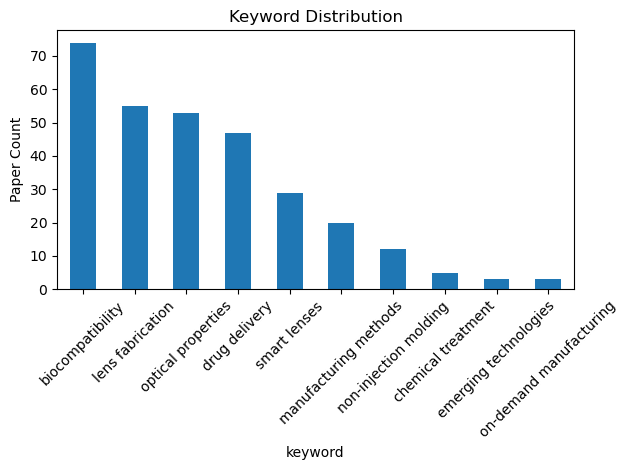

In [108]:
oa_trends_df['keyword'].value_counts().plot(
    kind='bar',
    title='Keyword Distribution',
    ylabel='Paper Count'
)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


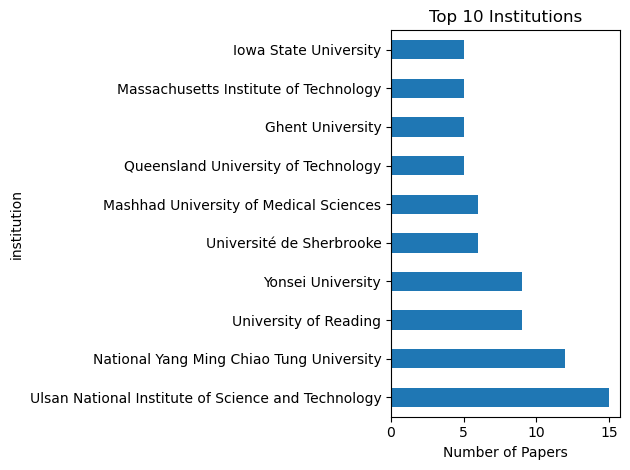

In [109]:
oa_trends_df['institution'].value_counts().head(10).plot(
    kind='barh',
    title='Top 10 Institutions',
    xlabel='Number of Papers'
)
plt.tight_layout()
plt.show()


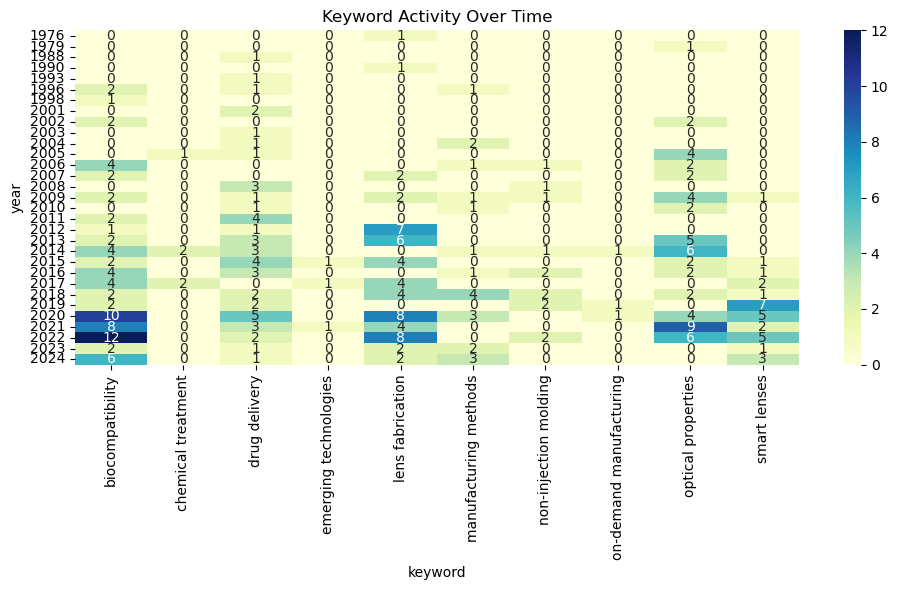

In [110]:
import seaborn as sns

heatmap_data = (
    oa_trends_df.groupby(['year', 'keyword'])
    .size()
    .unstack(fill_value=0)
)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap="YlGnBu", fmt="d")
plt.title("Keyword Activity Over Time")
plt.tight_layout()
plt.show()


# Patentview API

# FDA api

Documentation:
* https://www.accessdata.fda.gov/scripts/cdrh/cfdocs/cfpma/pma.cfm
* https://open.fda.gov/apis/